In [14]:
folder = '.../Atlas/scSPECTRA/onthefly/rodents_on_humans_V3/R2'  


In [ ]:
import pandas as pd
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example usage
cell_types = ['Podo']  

cell_type_list = ["Podo", "PEC", "PT", 
          "DTL_ATL", "TAL_MD", 
         "DCT_CNT_CD", "IC", 
         "Immune", "Stromal", "EC"]

#cell_type_list = ["PTS1", "PTS2", "PTS3"]  

folder = '.../Atlas/scSPECTRA/onthefly/rodents_on_humans_V3/R2'  # Replace with your folder path

# Load data for the specific cell type
cell_type = cell_types[0]
cell_type_df_features = pd.read_csv(f'{folder}/R2_{cell_type}.csv', index_col=0)
gene_sets = cell_type_df_features.columns.tolist()

# Combine data for all other cell types
cell_type_df = pd.DataFrame()
for other_cell_type in cell_types:
        other_df = pd.read_csv(f'{folder}/R2_{other_cell_type}.csv', index_col=0)
        cell_type_df = pd.concat([cell_type_df, other_df], axis=0)

# Combine data for all other cell types
not_cell_type_df = pd.DataFrame()
for other_cell_type in cell_type_list:
    if other_cell_type not in cell_types:
        other_df = pd.read_csv(f'{folder}/R2_{other_cell_type}.csv', index_col=0)
        not_cell_type_df = pd.concat([not_cell_type_df, other_df], axis=0)

# Prepare DataFrame for results
cols = ['mean_in_cell_type', 'mean_in_others', 'logfold_change', 'p_value', 'fdr_corrected_p_value']
statistics_results_df = pd.DataFrame(index=gene_sets, columns=cols)

# Loop through each gene set
for gene_set in gene_sets:
    # Extract R2 values for the current cell type and other cell types

    values_in_cell_type = cell_type_df[gene_set].dropna()
    values_in_others = not_cell_type_df[gene_set].dropna()

    # Perform Wilcoxon rank-sum test
    statistic, p_value = ranksums(values_in_cell_type, values_in_others, alternative='greater')

    # Calculate means and logfold change
    mean_in_cell_type = values_in_cell_type.mean()
    mean_in_others = values_in_others.mean()
    logfold_change = np.log2(mean_in_cell_type / mean_in_others) if mean_in_others != 0 else 'inf'

    # Store results
    statistics_results_df.loc[gene_set] = [mean_in_cell_type, mean_in_others, logfold_change, p_value, None]

# FDR correction
p_values = statistics_results_df['p_value'].astype(float).values
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
statistics_results_df['fdr_corrected_p_value'] = corrected_p_values

# Print or save the results
print(statistics_results_df)
# Optionally, save the results to a CSV file
# statistics_results_df.to_csv('/path/to/save/results.csv')


In [ ]:
sorted_results_df = statistics_results_df.sort_values(by='logfold_change', ascending = False)

sorted_results_df = sorted_results_df[sorted_results_df["fdr_corrected_p_value"] < 0.05]

sorted_results_df = sorted_results_df[sorted_results_df["mean_in_cell_type"] > 0.7]

sorted_results_df.head(50)

In [ ]:
sorted_results_df = statistics_results_df.sort_values(by='p_value')

#sorted_results_df = sorted_results_df[sorted_results_df["mean_in_cell_type"] > 0.7]

sorted_results_df.head(50)

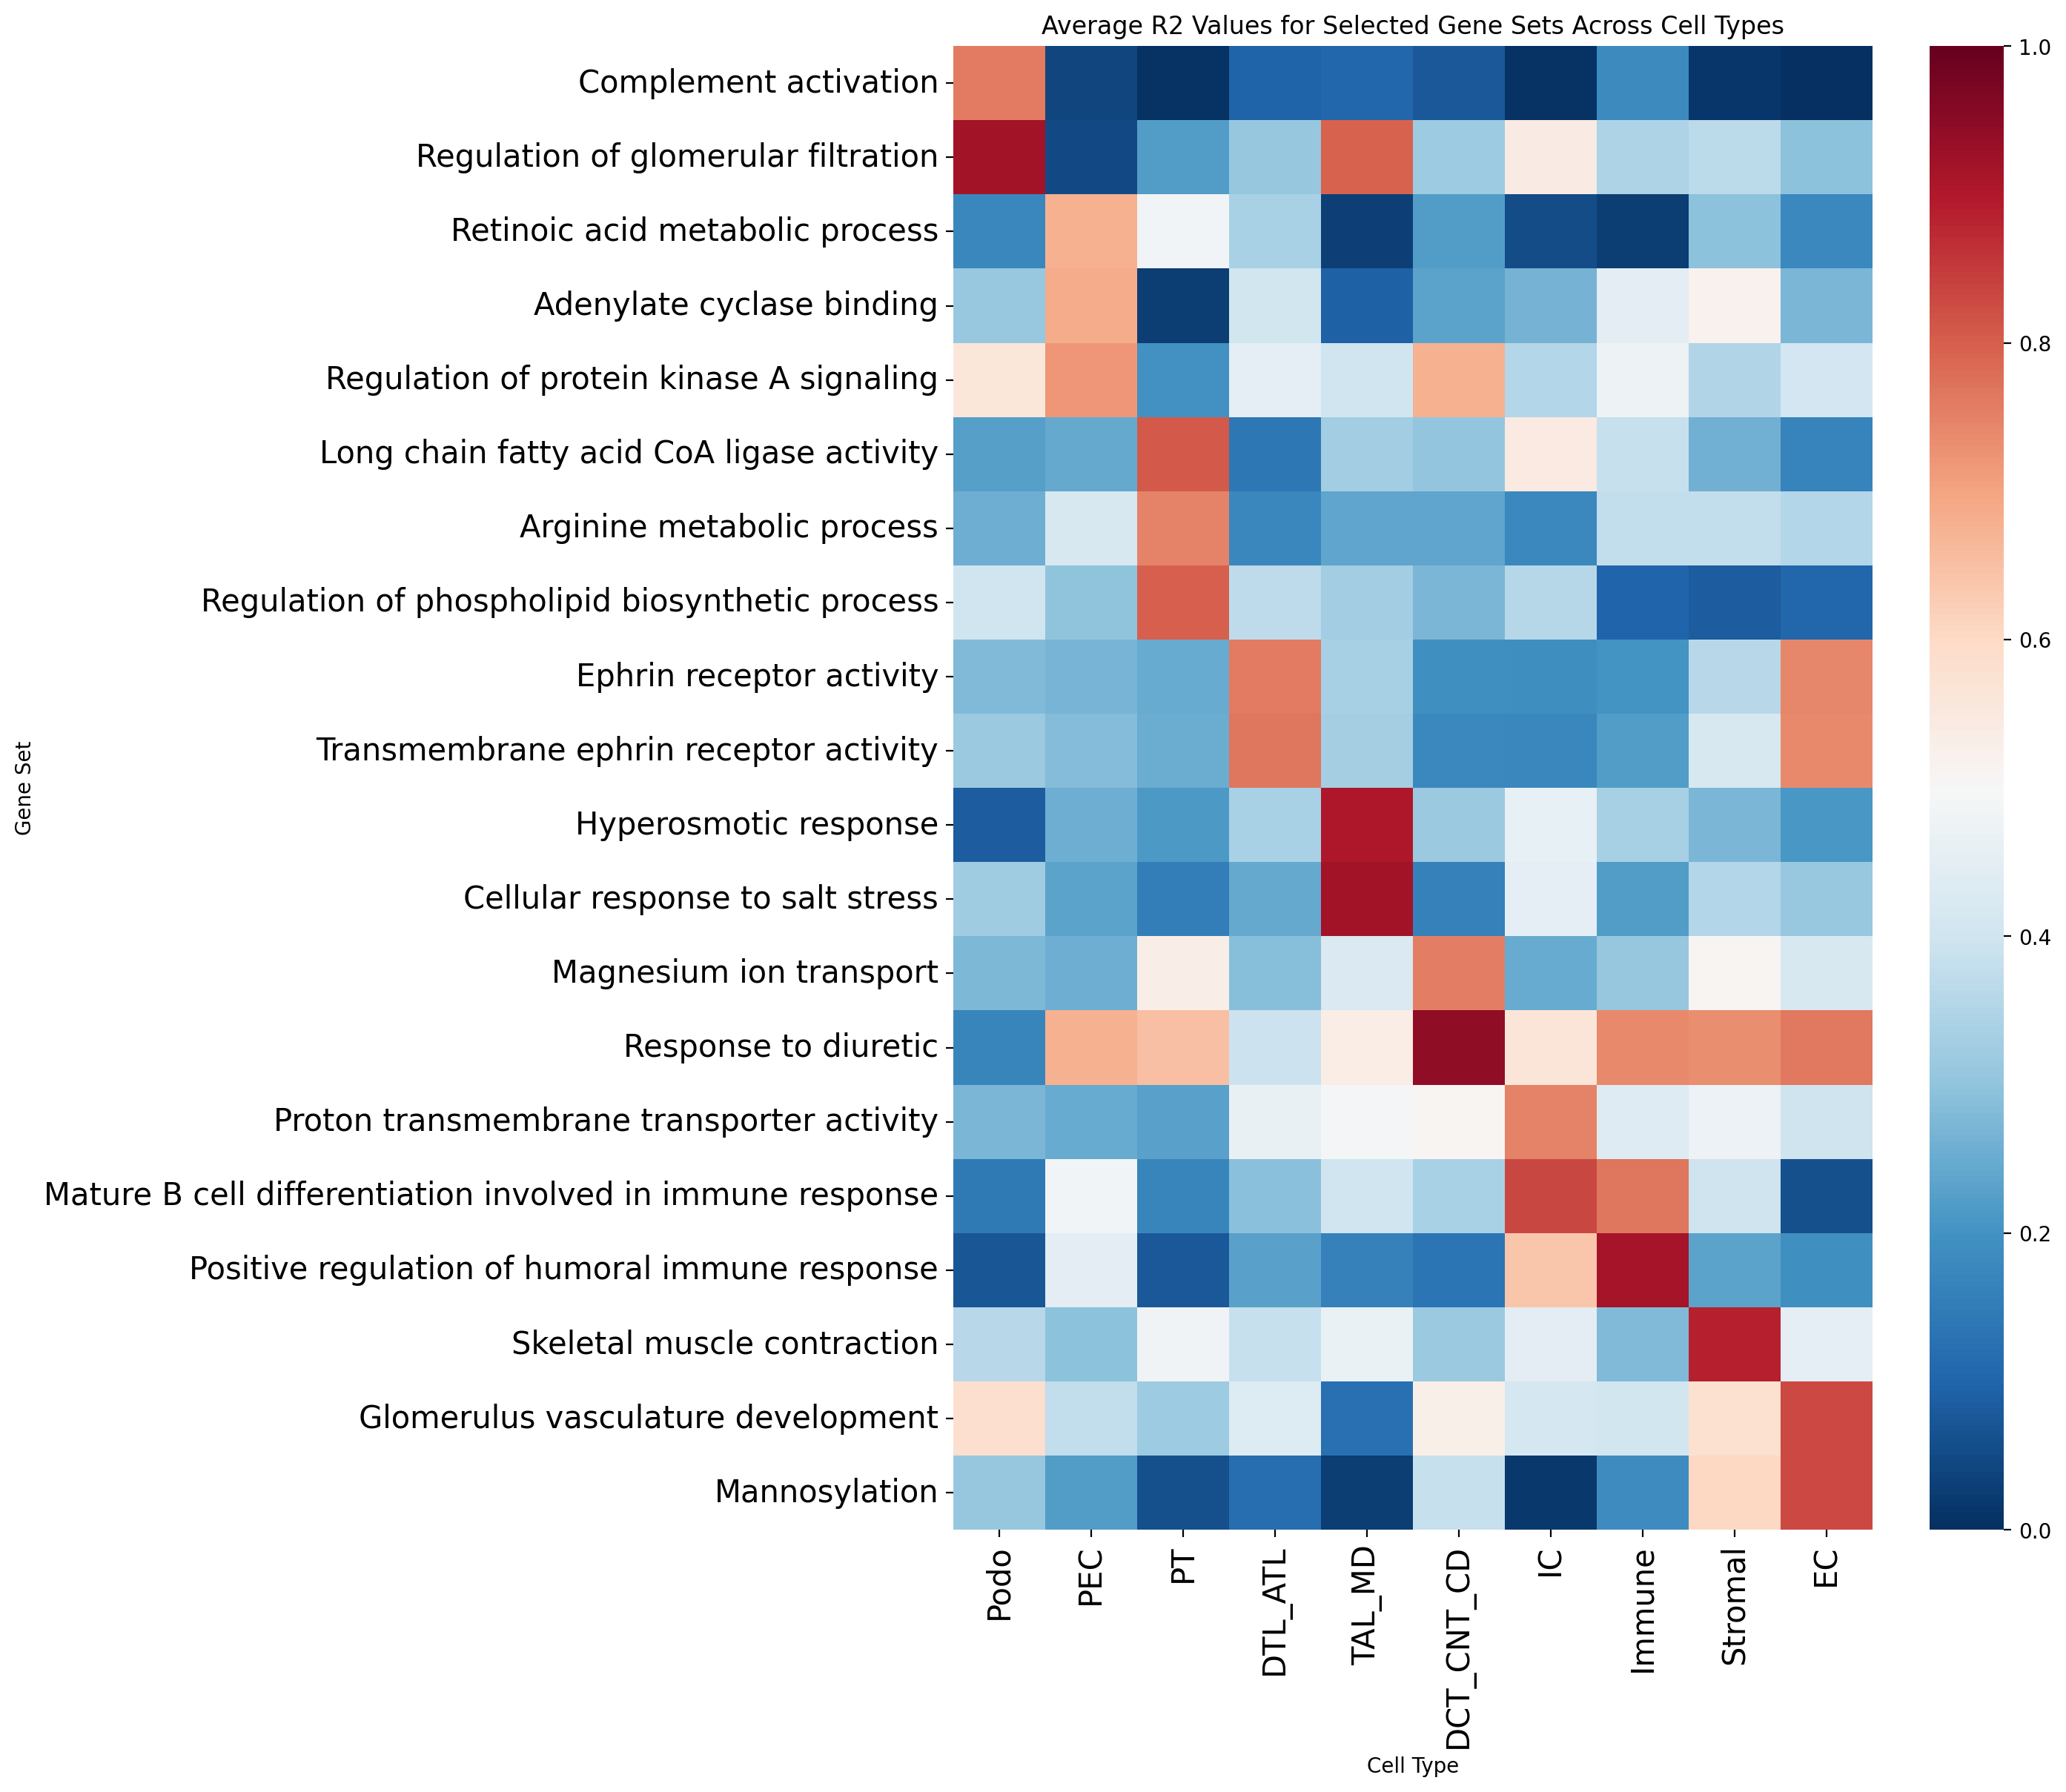

In [15]:
import re

# Define the list of selected gene sets
selected_gene_sets = ["GO.0006956.complement.activation.BP", "GO.0003093.regulation.of.glomerular.filtration.BP",
                      "GO.0042573.retinoic.acid.metabolic.process.BP" ,'GO.0008179.adenylate.cyclase.binding.MF', "GO.0010738.regulation.of.protein.kinase.A.signaling.BP", 
                      "GO.0004467.long.chain.fatty.acid.CoA.ligase.activity.MF", "GO.0006525.arginine.metabolic.process.BP", 
                      
                      "GO.0071071.regulation.of.phospholipid.biosynthetic.process.BP",
                      
                      "GO.0005003.ephrin.receptor.activity.MF", "GO.0005005.transmembrane.ephrin.receptor.activity.MF", 
                      "GO.0006972.hyperosmotic.response.BP", "GO.0071472.cellular.response.to.salt.stress.BP", 
                      "GO.0015693.magnesium.ion.transport.BP", "GO.0036270.response.to.diuretic.BP", 
                      "GO.0015078.proton.transmembrane.transporter.activity.MF", 
                      "GO.0002313.mature.B.cell.differentiation.involved.in.immune.response.BP", "GO.0002922.positive.regulation.of.humoral.immune.response.BP",
                      "GO.0003009.skeletal.muscle.contraction.BP",
                      "GO.0072012.glomerulus.vasculature.development.BP", "GO.0097502.mannosylation.BP",

                      
                      
                     
                     ]  # Replace with your list of selected gene sets


cell_type_list = ["Podo", "PEC", "PT", 
          "DTL_ATL", "TAL_MD", 
         "DCT_CNT_CD", "IC", 
         "Immune", "Stromal", "EC"]

# Create a DataFrame for average R2 values
avg_r2_df = pd.DataFrame(index=selected_gene_sets, columns=cell_type_list)

# Fill the DataFrame with average R2 values
for cell_type in cell_type_list:
    df = pd.read_csv(f'{folder}/R2_{cell_type}.csv', index_col=0)
    for gene_set in selected_gene_sets:
        avg_r2_df.at[gene_set, cell_type] = df[gene_set].mean()

        
# Process the index to modify the row names
new_index = []
for name in avg_r2_df.index:
    # Remove the "GO.xxxxxx." part
    name = re.sub(r'GO\.\d+\.', '', name)
    # Remove the last ".XX" part
    name = name.rsplit('.', 1)[0]
    # Replace dots with spaces
    name = name.replace('.', ' ')
    if name:
        name = name[0].upper() + name[1:]
    new_index.append(name)


# Update the DataFrame index
avg_r2_df.index = new_index        
        
        
        
        
        
# Plotting
plt.figure(figsize=(10, 13))
ax = sns.heatmap(avg_r2_df.astype(float), annot=False, cmap="RdBu_r", vmin = 0, vmax = 1)
plt.title('Average R2 Values for Selected Gene Sets Across Cell Types')
plt.ylabel('Gene Set')
plt.xlabel('Cell Type')

ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

/tmp/ipykernel_1451570/3249103080.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(r2_mouse_podo[gene_set], label="Mouse", shade=True, alpha=0.5, color="orange", clip=(0, 1))
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1451570/3249103080.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting

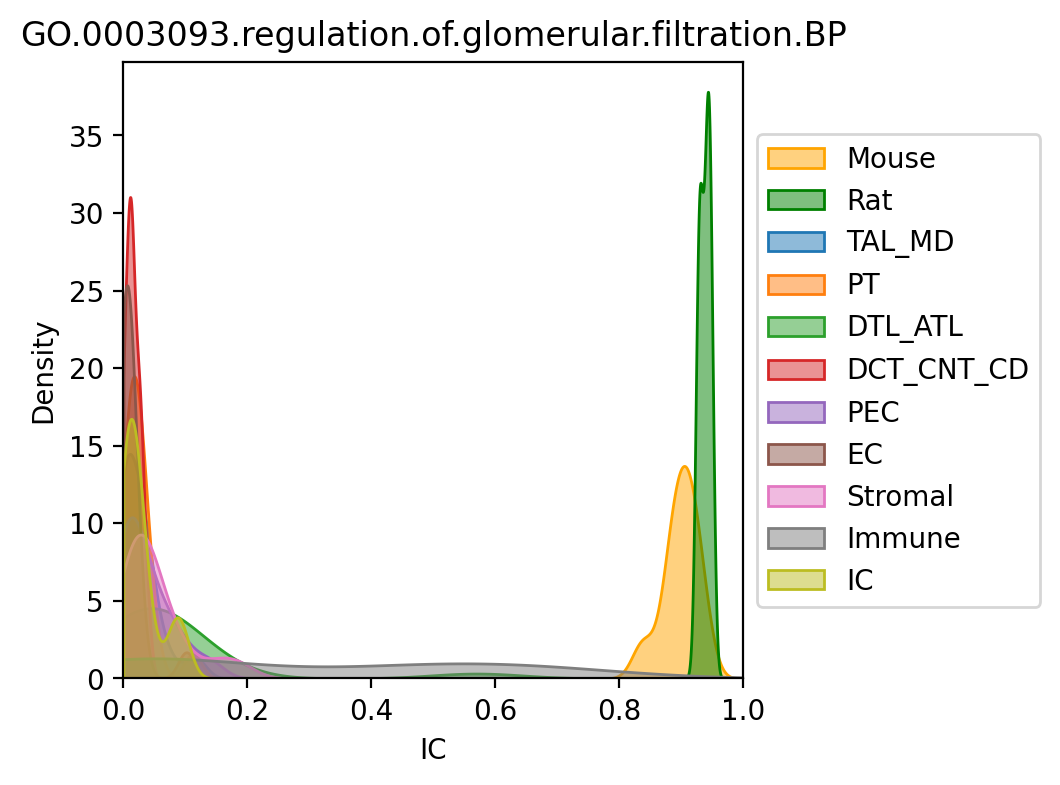

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paths
metadata_path = ".../Atlas/scSPECTRA/multispecies/multispecies_metadata_complete.csv"  # Replace with the correct metadata file path
r2_base_path = ".../Atlas/scSPECTRA/onthefly/rodents_on_humans_V3/onpodo/R2/R2_"

# Load the metadata
metadata = pd.read_csv(metadata_path)

# Set the cell type and gene set of interest
cell_type = "Podo"  # Example cell type
#gene_set = "GO.0001573.ganglioside.metabolic.process.BP"  # Replace with the actual gene set name
#gene_set = "GO.0010893.positive.regulation.of.steroid.biosynthetic.process.BP"  # Replace with the actual gene set name
gene_set = "GO.0003093.regulation.of.glomerular.filtration.BP"


# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]


# Subset the metadata to include only the samples present in the R2 file
metadata_subset = metadata[metadata['orig_ident'].isin(r2_subset.index)]


# Create lists of samples for rat and mouse


mouse_cells = metadata_subset[metadata_subset['species'] == 'mouse']['orig_ident'].tolist()
rat_cells = metadata_subset[metadata_subset['species'] == 'rat']['orig_ident'].tolist()

r2_mouse_podo = r2_subset.loc[mouse_cells]
r2_rat_podo = r2_subset.loc[rat_cells]

# Plotting with new color scheme
sns.kdeplot(r2_mouse_podo[gene_set], label="Mouse", shade=True, alpha=0.5, color="orange", clip=(0, 1))
sns.kdeplot(r2_rat_podo[gene_set], label="Rat", shade=True, alpha=0.5, color="green", clip=(0, 1))


# Set the cell type and gene set of interest
cell_type = "TAL_MD"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))


# Set the cell type and gene set of interest
cell_type = "PT"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))




# Set the cell type and gene set of interest
cell_type = "DTL_ATL"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))




# Set the cell type and gene set of interest
cell_type = "DCT_CNT_CD"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))





# Set the cell type and gene set of interest
cell_type = "PEC"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))








# Set the cell type and gene set of interest
cell_type = "EC"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))






# Set the cell type and gene set of interest
cell_type = "Stromal"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))






# Set the cell type and gene set of interest
cell_type = "Immune"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))






# Set the cell type and gene set of interest
cell_type = "IC"  # Example cell type

# Read the R2 file for the specific cell type
r2_file_path = f"{r2_base_path}{cell_type}.csv"
r2_data = pd.read_csv(r2_file_path, index_col=0)

# Subset the R2 data to the gene set of interest
r2_subset = r2_data[[gene_set]]

sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, clip=(0, 1))






plt.title(gene_set)
plt.xlabel(cell_type)
plt.ylabel("Density")

# Move the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()

/tmp/ipykernel_1451570/368510599.py:45: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(r2_subset[gene_set], label="Rodent Podocytes", shade=True, alpha=0.5, color="black", clip=(0, 1))
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1451570/368510599.py:53: FutureWarning: 

`shade` is now deprecated in favor of `fill`; set

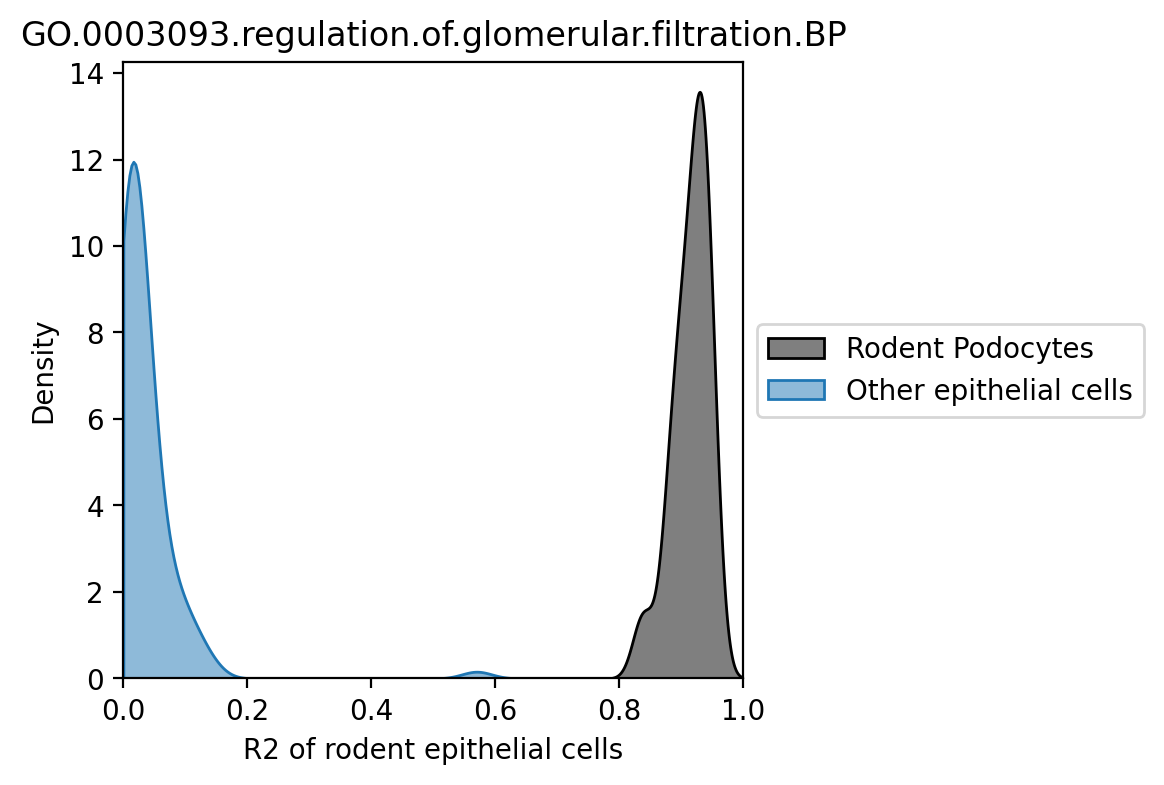

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paths
metadata_path = ".../Atlas/scSPECTRA/multispecies/multispecies_metadata_complete.csv"  # Replace with the correct metadata file path
r2_base_path = "../Atlas/scSPECTRA/onthefly/rodents_on_humans_V3/onpodo/R2/R2_"

# Load the metadata
metadata = pd.read_csv(metadata_path)

# Set the cell type and gene set of interest
cell_type = "Podo"  # Example cell type
#gene_set = "GO.0001573.ganglioside.metabolic.process.BP"  # Replace with the actual gene set name
#gene_set = "GO.0010893.positive.regulation.of.steroid.biosynthetic.process.BP"  # Replace with the actual gene set name
gene_set = "GO.0003093.regulation.of.glomerular.filtration.BP"


# Create an empty DataFrame for aggregating other cell types
other_cell_types_data = pd.DataFrame()

# List of all cell types to process
#cell_types = ["Podo", "TAL_MD", "PT", "DTL_ATL", "DCT_CNT_CD", "PEC", "EC", "Stromal", "Immune", "IC"]
cell_types = ["Podo", "TAL_MD", "PT", "DTL_ATL", "DCT_CNT_CD", "PEC", "IC"]


for cell_type in cell_types:
    r2_file_path = f"{r2_base_path}{cell_type}.csv"
    r2_data = pd.read_csv(r2_file_path, index_col=0)
    r2_subset = r2_data[[gene_set]]

    if cell_type == "Podo":
        # Subset the metadata for mouse and rat cells
        metadata_subset = metadata[metadata['orig_ident'].isin(r2_subset.index)]
        #mouse_cells = metadata_subset[metadata_subset['species'] == 'mouse']['orig_ident'].tolist()
        #rat_cells = metadata_subset[metadata_subset['species'] == 'rat']['orig_ident'].tolist()

        #r2_mouse_podo = r2_subset.loc[mouse_cells]
        #r2_rat_podo = r2_subset.loc[rat_cells]

        # Plot for mouse and rat podocytes
        #sns.kdeplot(r2_mouse_podo[gene_set], label="Mouse Podo", shade=True, alpha=0.5, color="orange", clip=(0, 1))
        
        #sns.kdeplot(r2_rat_podo[gene_set], label="Rat Podo", shade=True, alpha=0.5, color="green", clip=(0, 1))
        sns.kdeplot(r2_subset[gene_set], label="Rodent Podocytes", shade=True, alpha=0.5, color="black", clip=(0, 1))
        
        
    else:
        # Add the data to the aggregate DataFrame
        other_cell_types_data = pd.concat([other_cell_types_data, r2_subset])

# Plotting the aggregated other cell types
sns.kdeplot(other_cell_types_data[gene_set], label="Other epithelial cells", shade=True, alpha=0.5, clip=(0, 1))

plt.title(gene_set)
plt.xlabel("R2 of rodent epithelial cells")
plt.ylabel("Density")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.show()

/tmp/ipykernel_1451570/535174094.py:45: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(r2_subset[gene_set], label="Rodent Podocytes", shade=True, alpha=0.5, color="black", clip=(0, 1))
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1451570/535174094.py:53: FutureWarning: 

`shade` is now deprecated in favor of `fill`; set

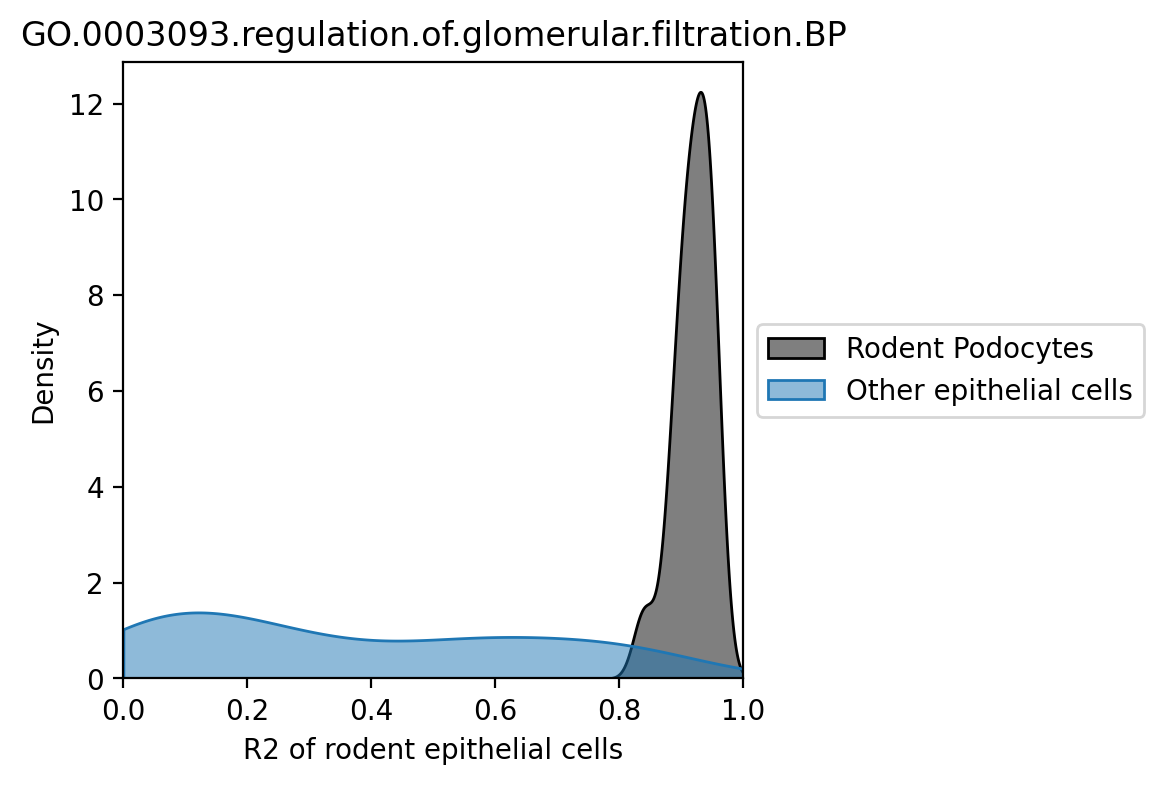

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the paths
metadata_path = ".../Atlas/scSPECTRA/multispecies/multispecies_metadata_complete.csv"  # Replace with the correct metadata file path
r2_base_path = ".../Atlas/scSPECTRA/onthefly/rodents_on_humans_V3/R2/R2_"

# Load the metadata
metadata = pd.read_csv(metadata_path)

# Set the cell type and gene set of interest
cell_type = "Podo"  # Example cell type
#gene_set = "GO.0001573.ganglioside.metabolic.process.BP"  # Replace with the actual gene set name
#gene_set = "GO.0010893.positive.regulation.of.steroid.biosynthetic.process.BP"  # Replace with the actual gene set name
gene_set = "GO.0003093.regulation.of.glomerular.filtration.BP"


# Create an empty DataFrame for aggregating other cell types
other_cell_types_data = pd.DataFrame()

# List of all cell types to process
#cell_types = ["Podo", "TAL_MD", "PT", "DTL_ATL", "DCT_CNT_CD", "PEC", "EC", "Stromal", "Immune", "IC"]
cell_types = ["Podo", "TAL_MD", "PT", "DTL_ATL", "DCT_CNT_CD", "PEC", "IC"]


for cell_type in cell_types:
    r2_file_path = f"{r2_base_path}{cell_type}.csv"
    r2_data = pd.read_csv(r2_file_path, index_col=0)
    r2_subset = r2_data[[gene_set]]

    if cell_type == "Podo":
        # Subset the metadata for mouse and rat cells
        metadata_subset = metadata[metadata['orig_ident'].isin(r2_subset.index)]
        #mouse_cells = metadata_subset[metadata_subset['species'] == 'mouse']['orig_ident'].tolist()
        #rat_cells = metadata_subset[metadata_subset['species'] == 'rat']['orig_ident'].tolist()

        #r2_mouse_podo = r2_subset.loc[mouse_cells]
        #r2_rat_podo = r2_subset.loc[rat_cells]

        # Plot for mouse and rat podocytes
        #sns.kdeplot(r2_mouse_podo[gene_set], label="Mouse Podo", shade=True, alpha=0.5, color="orange", clip=(0, 1))
        
        #sns.kdeplot(r2_rat_podo[gene_set], label="Rat Podo", shade=True, alpha=0.5, color="green", clip=(0, 1))
        sns.kdeplot(r2_subset[gene_set], label="Rodent Podocytes", shade=True, alpha=0.5, color="black", clip=(0, 1))
        
        
    else:
        # Add the data to the aggregate DataFrame
        other_cell_types_data = pd.concat([other_cell_types_data, r2_subset])

# Plotting the aggregated other cell types
sns.kdeplot(other_cell_types_data[gene_set], label="Other epithelial cells", shade=True, alpha=0.5, clip=(0, 1))

plt.title(gene_set)
plt.xlabel("R2 of rodent epithelial cells")
plt.ylabel("Density")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.show()

/tmp/ipykernel_1451570/2035842421.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, color=cell_colors[cell_type], clip=(0, 1))
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gpfs/o_kloetzer/miniforge3/envs/scvi-pip/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1451570/2035842421.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fi

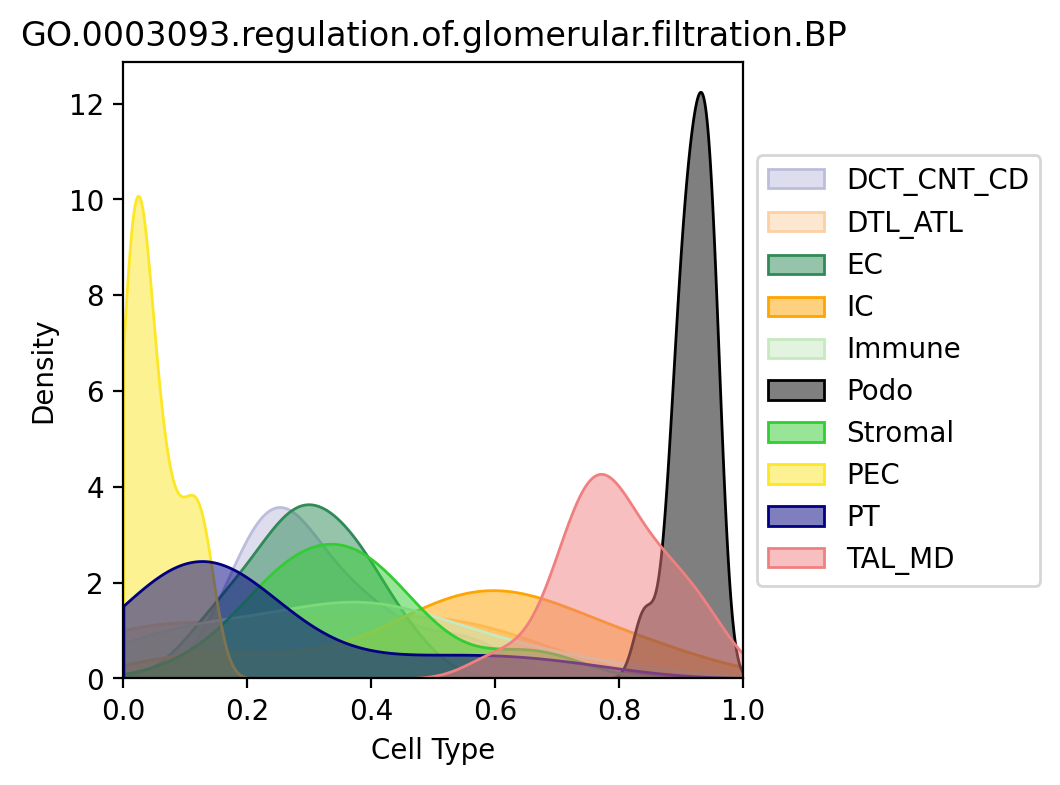

In [26]:


# Define the color mapping for each cell type
cell_colors = {
    "DCT_CNT_CD": "#bcbddc",
    "DTL_ATL": "#fdd0a2",
    "EC": "seagreen",
    "IC": "orange",
    "Immune": "#c7e9c0",
    "Podo": "black",
    "Stromal": "limegreen",
    "PEC": "#fde725",
    "PT": "navy",
    "TAL_MD": "lightcoral",
   
}

# List of all cell types to process
cell_types = list(cell_colors.keys())

for cell_type in cell_types:
    r2_file_path = f"{r2_base_path}{cell_type}.csv"
    r2_data = pd.read_csv(r2_file_path, index_col=0)
    r2_subset = r2_data[[gene_set]]

    # Plot each cell type with its respective color
    sns.kdeplot(r2_subset[gene_set], label=cell_type, shade=True, alpha=0.5, color=cell_colors[cell_type], clip=(0, 1))

plt.title(gene_set)
plt.xlabel("Cell Type")
plt.ylabel("Density")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.show()
